# Meld analysis 

Author: Zhiyuan Hu \
Date: 14 Dec 2023 \
Last modified: 21 Jan 2024

In [1]:
import pandas as pd
import numpy as np
import graphtools as gt
import matplotlib.pyplot as plt
import cmocean
import phate
import scprep
import meld
import sklearn
import tempfile
import os
import scanpy as sc

In [2]:
# making sure plots & clusters are reproducible
np.random.seed(42)

In [3]:
adata = sc.read_h5ad("perturb_seq/analysis/clustering/output_p1top11/seu_NC_clustered.h5ad")
# Define the clusters to exclude, ensuring they are of the same type
clusters_to_exclude = ['1', '2', '3', '8', '11', '16','17']

# Create a boolean mask to filter out unwanted clusters
mask = ~adata.obs['seurat_clusters'].isin(clusters_to_exclude)
mask.value_counts()

# Apply the mask to filter the AnnData object
adata = adata[mask].copy()

data = adata.to_df() # to make sure that it is raw data (counts), not scaled data
data

CR383668.1  fgfr1op2  si:dkey-21h14.12  \
p1_AAACGGGAGCTAGTTC-1          0.0  1.968357               0.0   
p1_AAACGGGCAAAGAATC-1          0.0  0.952317               0.0   
p1_AAACGGGCAATGTAAG-1          0.0  0.962384               0.0   
p1_AAACGGGCAGCAGTTT-1          0.0  0.000000               0.0   
p1_AAACGGGGTAGCGTAG-1          0.0  0.946222               0.0   
...                            ...       ...               ...   
p11_TTTGCGCAGAGTAATC-1         0.0  0.000000               0.0   
p11_TTTGGTTTCAACTCTT-1         0.0  0.000000               0.0   
p11_TTTGGTTTCCTATTCA-1         0.0  0.000000               0.0   
p11_TTTGGTTTCTAACTCT-1         0.0  0.000000               0.0   
p11_TTTGTCAAGGACAGCT-1         0.0  2.881373               0.0   

                        si:dkey-285e18.2   znf1114  si:dkey-21h14.10  \
p1_AAACGGGAGCTAGTTC-1                0.0  0.000000               0.0   
p1_AAACGGGCAAAGAATC-1                0.0  0.000000               0.0   
p1_AAACGGGCAATGTAAG-1                0.0  0.953763               0.0   
p1_AAACGGGCAGCAGTTT-1                0.0  0.000000               0.0   
p1_AAACGGGGTAGCGTAG-1                0.0  0.000000               0.0   
...                                  ...       ...               ...   
p11_TTTGCGCAGAGTAATC-1               0.0  0.000000               0.0   
p11_TTTGGTTTCAACTCTT-1               0.0  0.000000               0.0   
p11_TTTGGTTTCCTATTCA-1               0.0  0.000000               0.0   
p11_TTTGGTTTCTAACTCT-1               0.0  0.000000               0.0   
p11_TTTGTCAAGGACAGCT-1               0.0  0.000000               0.0   

                        ENSDARG00000076014  si:dkey-199m13.5  erc1b  \
p1_AAACGGGAGCTAGTTC-1             5.890944               0.0    0.0   
p1_AAACGGGCAAAGAATC-1             2.785773               0.0    0.0   
p1_AAACGGGCAATGTAAG-1             0.000000               0.0    0.0   
p1_AAACGGGCAGCAGTTT-1             1.787435               0.0    0.0   
p1_AAACGGGGTAGCGTAG-1             0.000000               0.0    0.0   
...                                    ...               ...    ...   
p11_TTTGCGCAGAGTAATC-1            0.000000               0.0    0.0   
p11_TTTGGTTTCAACTCTT-1            0.909906               0.0    0.0   
p11_TTTGGTTTCCTATTCA-1            0.000000               0.0    0.0   
p11_TTTGGTTTCTAACTCT-1            0.000000               0.0    0.0   
p11_TTTGTCAAGGACAGCT-1            1.710630               0.0    0.0   

                        si:dkey-199m13.4  ...  CABZ01074745.1  CABZ01118270.1  \
p1_AAACGGGAGCTAGTTC-1                0.0  ...             0.0             0.0   
p1_AAACGGGCAAAGAATC-1                0.0  ...             0.0             0.0   
p1_AAACGGGCAATGTAAG-1                0.0  ...             0.0             0.0   
p1_AAACGGGCAGCAGTTT-1                0.0  ...             0.0             0.0   
p1_AAACGGGGTAGCGTAG-1                0.0  ...             0.0             0.0   
...                                  ...  ...             ...             ...   
p11_TTTGCGCAGAGTAATC-1               0.0  ...             0.0             0.0   
p11_TTTGGTTTCAACTCTT-1               0.0  ...             0.0             0.0   
p11_TTTGGTTTCCTATTCA-1               0.0  ...             0.0             0.0   
p11_TTTGGTTTCTAACTCT-1               0.0  ...             0.0             0.0   
p11_TTTGTCAAGGACAGCT-1               0.0  ...             0.0             0.0   

                        ENSDARG00000116774  CABZ01088864.1  CABZ01110379.1  \
p1_AAACGGGAGCTAGTTC-1                  0.0             0.0        0.000000   
p1_AAACGGGCAAAGAATC-1                  0.0             0.0        0.000000   
p1_AAACGGGCAATGTAAG-1                  0.0             0.0        0.000000   
p1_AAACGGGCAGCAGTTT-1                  0.0             0.0        0.939902   
p1_AAACGGGGTAGCGTAG-1                  0.0             0.0        0.000000   
...                                    ...             ...             .

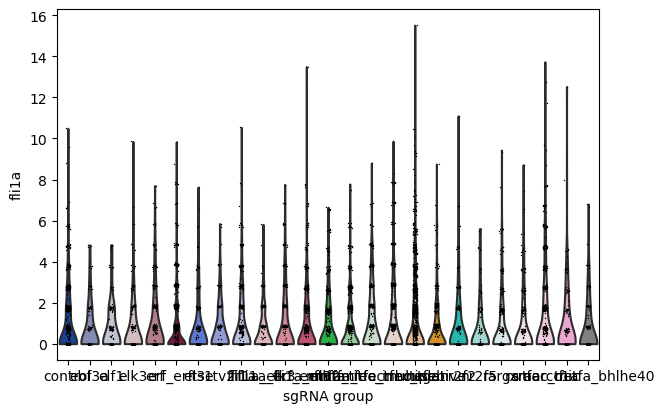

In [4]:
# use violin plots to check if it is raw count matrix
os.chdir("perturb_seq/analysis/differential_analysis/figures/meld_calculateLikelihood")
sc.pl.violin(adata,keys="fli1a", groupby = "sgRNA_group")

metadata = adata.obs

## Preprocessing

In [6]:
data_pca = pd.DataFrame(adata.obsm['X_pca'])
data_pca.index = adata.obs_names
phate_op = phate.PHATE(knn=5, decay=15, gamma=1, n_jobs=-1)
data_phate = phate_op.fit_transform(data_pca)

# Convert the PHATE coordinates to a DataFrame
phate_df = pd.DataFrame(data_phate, columns=['PHATE1', 'PHATE2'])

# Save to a CSV file
phate_df.index = data_pca.index

Calculating PHATE...
  Running PHATE on 12393 observations and 50 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 9.83 seconds.
    Calculating affinities...
    Calculated affinities in 3.54 seconds.
  Calculated graph and diffusion operator in 13.43 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 1.34 seconds.
    Calculating KMeans...
    Calculated KMeans in 8.59 seconds.
  Calculated landmark operator in 10.91 seconds.
  Calculating optimal t...
    Automatically selected t = 25
  Calculated optimal t in 3.33 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 1.44 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 3.63 seconds.
Calculated PHATE in 32.75 seconds.


<Axes: xlabel='PHATE1', ylabel='PHATE2'>

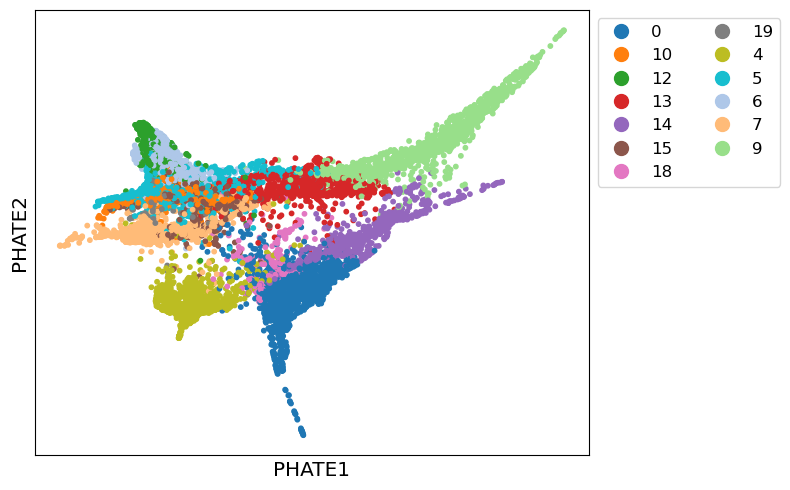

In [7]:
scprep.plot.scatter2d(data_phate, c=metadata['seurat_clusters'],
                      legend_anchor=(1,1), figsize=(8,5), s=10, label_prefix='PHATE', ticks=False, filename = "scatter_phate_clusters.png")

<Axes: xlabel='PHATE1', ylabel='PHATE2'>

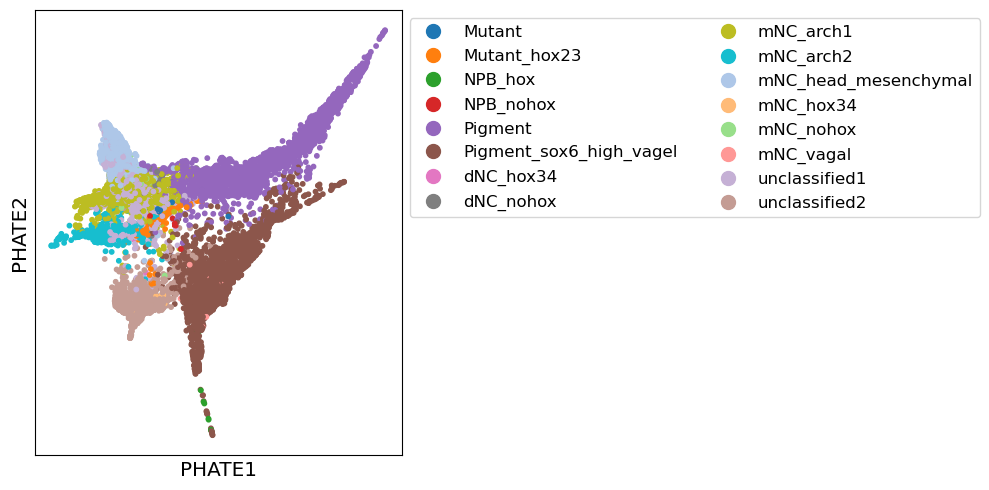

In [8]:
scprep.plot.scatter2d(data_phate, c=metadata['cell_anno'],
                      legend_anchor=(1,1), figsize=(10,5), s=10, 
                      label_prefix='PHATE', ticks=False, filename = "scatter_phate_cellAnno.png")

## Using MELD to calculate sample-associated density estimates and relative likelihood

In [9]:
# Using MELD to calculate sample-associated density estimates and relative likelihood
metadata['genotype_name'] = metadata['sgRNA_group']
metadata['genotype'] = metadata['sgRNA_group']
metadata['replicate'] = "A"
metadata

nCount_RNA  nFeature_RNA sample  percent.mt  \
p1_AAACGGGAGCTAGTTC-1    9374.373090          3125     p1    0.601578   
p1_AAACGGGCAAAGAATC-1   16617.288939          3908     p1    0.752648   
p1_AAACGGGCAATGTAAG-1   10564.695306          3262     p1    0.888390   
p1_AAACGGGCAGCAGTTT-1   17754.127675          3934     p1    0.579913   
p1_AAACGGGGTAGCGTAG-1   15028.838200          3638     p1    0.467387   
...                              ...           ...    ...         ...   
p11_TTTGCGCAGAGTAATC-1   6202.170676          2499    p11    0.776390   
p11_TTTGGTTTCAACTCTT-1   3644.718485          1857    p11    1.794744   
p11_TTTGGTTTCCTATTCA-1   8422.826902          3344    p11    0.510019   
p11_TTTGGTTTCTAACTCT-1   6612.583387          2661    p11    0.449287   
p11_TTTGTCAAGGACAGCT-1  11372.933636          3694    p11    0.594269   

                       RNA_snn_res.1 seurat_clusters         sgRNA_group  \
p1_AAACGGGAGCTAGTTC-1              3               6     fli1a_erf_erfl3   
p1_AAACGGGCAAAGAATC-1             12               9     fli1a_erf_erfl3   
p1_AAACGGGCAATGTAAG-1             10               4  mitfa_tfec_inhouse   
p1_AAACGGGCAGCAGTTT-1              4               7     fli1a_erf_erfl3   
p1_AAACGGGGTAGCGTAG-1              1               5     fli1a_erf_erfl3   
...                              ...             ...                 ...   
p11_TTTGCGCAGAGTAATC-1             2               0               ebf3a   
p11_TTTGGTTTCAACTCTT-1             3               6                elf1   
p11_TTTGGTTTCCTATTCA-1             1               5               nr2f2   
p11_TTTGGTTTCTAACTCT-1             1              15               ebf3a   
p11_TTTGTCAAGGACAGCT-1             3               6           multiplet   

                       RNA_snn_res.0.8                cell_anno  \
p1_AAACGGGAGCTAGTTC-1                6     mNC_head_mesenchymal   
p1_AAACGGGCAAAGAATC-1                9                  Pigment   
p1_AAACGGGCAATGTAAG-1                4            unclassified2   
p1_AAACGGGCAGCAGTTT-1                7                mNC_arch2   
p1_AAACGGGGTAGCGTAG-1                5            unclassified1   
...                                ...                      ...   
p11_TTTGCGCAGAGTAATC-1               0  Pigment_sox6_high_vagel   
p11_TTTGGTTTCAACTCTT-1               6     mNC_head_mesenchymal   
p11_TTTGGTTTCCTATTCA-1               5                mNC_arch1   
p11_TTTGGTTTCTAACTCT-1              15            unclassified1   
p11_TTTGTCAAGGACAGCT-1               6     mNC_head_mesenchymal   

                             genotype_name            genotype replicate  
p1_AAACGGGAGCTAGTTC-1      fli1a_erf_erfl3     fli1a_erf_erfl3         A  
p1_AAACGGGCAAAGAATC-1      fli1a_erf_erfl3     fli1a_erf_erfl3         A  
p1_AAACGGGCAATGTAAG-1   mitfa_tfec_inhouse  mitfa_tfec_inhouse         A  
p1_AAACGGGCAGCAGTTT-1      fli1a_erf_erfl3     fli1a_erf_erfl3         A  
p1_AAACGGGGTAGCGTAG-1      fli1a_erf_erfl3     fli1a_erf_erfl3         A  
...                                    ...                 ...       ...  
p11_TTTGCGCAGAGTAATC-1               ebf3a               ebf3a         A  
p11_TTTGGTTTCAACTCTT-1                elf1                elf1         A  
p11_TTTGGTTTCCTATTCA-1               nr2f2               nr2f2         A  
p11_TTTGGTTTCTAACTCT-1               ebf3a               ebf3a         A  
p11_TTTGTCAAGGACAGCT-1           multiplet           multiplet         A  

[12393 rows x 12 columns]

### Parameter search

In [10]:
# benchmarker = meld.Benchmarker()

# # 3D PHATE components are used to create the ground truth PDF
# benchmarker.fit_phate(data_pca);

In [11]:
# fig, axes = plt.subplots(1,3, figsize=(12,4))

# for i, ax in enumerate(axes):
#     benchmarker.generate_ground_truth_pdf()
#     scprep.plot.scatter2d(data_phate, c=benchmarker.pdf, cmap=meld.utils.get_meld_cmap(),
#                      vmin=0, vmax=1, ticks=False, ax=ax)
    
# fig.tight_layout()

In [12]:
from joblib import Parallel, delayed

def simulate_pdf_calculate_likelihood(benchmarker, seed, beta):
    benchmarker.set_seed(seed)
    benchmarker.generate_ground_truth_pdf()
    
    benchmarker.generate_sample_labels()
    benchmarker.calculate_MELD_likelihood(beta=beta)
    MELD_mse = benchmarker.calculate_mse(benchmarker.expt_likelihood)
    return MELD_mse, seed, beta, benchmarker.graph.knn

In [13]:
knn_range = np.arange(1,25)
beta_range = np.arange(1,200)

### Loading Parameter Search Results

In [16]:
import os, tempfile
results = pd.read_pickle("perturb_seq/analysis/differential_analysis/data/meld/parameter_search_results.pkl")

# We want to take the average of each set of random seeds for each combination of beta and knn values
results_wide = results.groupby(['beta', 'knn']).mean().sort_values(by='MSE').reset_index()

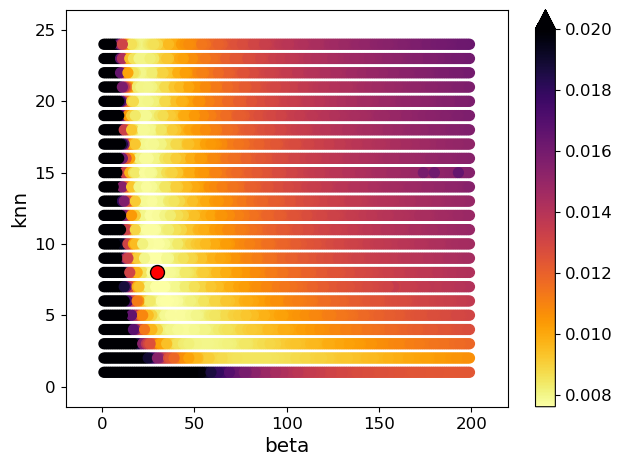

In [17]:
ax = scprep.plot.scatter(results_wide['beta'], results_wide['knn'], 
                         s=50, c=results_wide['MSE'], vmax=0.02, cmap='inferno_r')

# Highlight the top performing combination with a large red dot
top_result = results_wide.sort_values('MSE').iloc[0]
ax.scatter(top_result['beta'], top_result['knn'], c='r', s=100, linewidth=1, edgecolor='k')

In [18]:
results_wide

beta  knn       MSE  seed
0       30    8  0.007607  12.0
1       31    8  0.007607  12.0
2       31    7  0.007608  12.0
3       32    7  0.007610  12.0
4       28    9  0.007614  12.0
...    ...  ...       ...   ...
4771     1    5  0.173939  12.0
4772     1    4  0.174264  12.0
4773     1    3  0.177882  12.0
4774     1    2  0.181574  12.0
4775     1    1  0.188186  12.0

[4776 rows x 4 columns]

In [19]:
top_result
# beta    30.000000
# knn      8.000000
# MSE      0.007607
# seed    12.000000

beta    30.000000
knn      8.000000
MSE      0.007607
seed    12.000000
Name: 0, dtype: float64

### Run MELD

In [20]:
# This is a helper function to apply L1 normalization across the densities for each replicate
def replicate_normalize_densities(sample_densities, replicate):
    # Get the unique replicates
    replicates = np.unique(replicate)
    sample_likelihoods = sample_densities.copy()
    for rep in replicates:
        # Select the columns of `sample_densities` for that replicate
        curr_cols = sample_densities.columns[[col.endswith(rep) for col in sample_densities.columns]]
        curr_densities = sample_densities[curr_cols]
        # Apply L1 normalization
        sample_likelihoods[curr_cols] = sklearn.preprocessing.normalize(curr_densities, norm='l1')
    return sample_likelihoods



In [21]:
beta=top_result['beta']
knn=int(top_result['knn'])


## select two conditions for comperison

Building graph on 779 samples and 50 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 0.05 seconds.
  Calculating affinities...
Calculated graph and diffusion operator in 0.07 seconds.


/tmp/ipykernel_12687/3730242449.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_small['replicate'] = random_assignments
/tmp/ipykernel_12687/3730242449.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_small['sample_labels'] = metadata_small['sgRNA_group'].astype(str) + metadata_small['replicate']


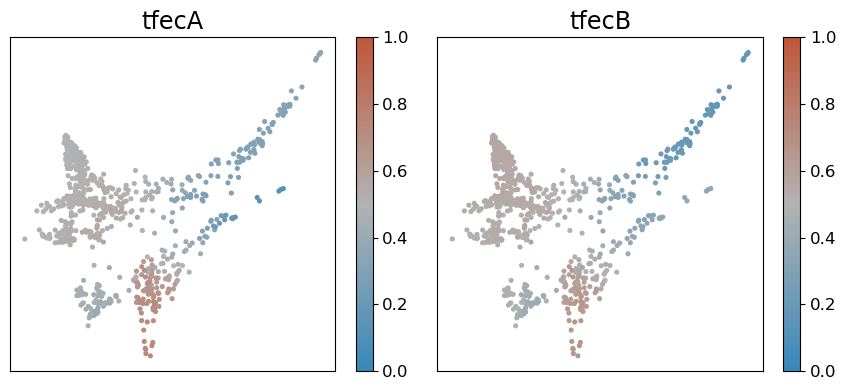

In [22]:
# Create a boolean mask for the condition
condition = (metadata['sgRNA_group'] == 'control') | (metadata['sgRNA_group'] == 'tfec')
# Use the mask to subset the DataFrame
metadata_small = metadata[condition]

# Assuming metadata is a DataFrame with a 'replicate' column
# Create an array of random 'A' and 'B' values
random_assignments = np.random.choice(['A', 'B'], size=len(metadata_small))

# Assign the random values to the 'replicate' column
metadata_small['replicate'] = random_assignments

meld_op = meld.MELD(beta=beta, knn=knn)
metadata_small['sample_labels'] = metadata_small['sgRNA_group'].astype(str) + metadata_small['replicate']
sample_densities = meld_op.fit_transform(data_pca[condition], sample_labels=metadata_small['sample_labels'])

sample_likelihoods = replicate_normalize_densities(sample_densities, metadata_small['replicate'])
  
#  sample associated relative likelihoods for each condition.
experimental_samples = ['tfecA','tfecB']

fig, axes = plt.subplots(1,2, figsize=(8.7,4))
for curr_sample, ax in zip(experimental_samples, axes):
    scprep.plot.scatter2d(data_phate[condition], c=sample_likelihoods[curr_sample], cmap=meld.get_meld_cmap(),
                          vmin=0, vmax=1,
                          title=curr_sample, ticks=False, ax=ax)
fig.tight_layout()



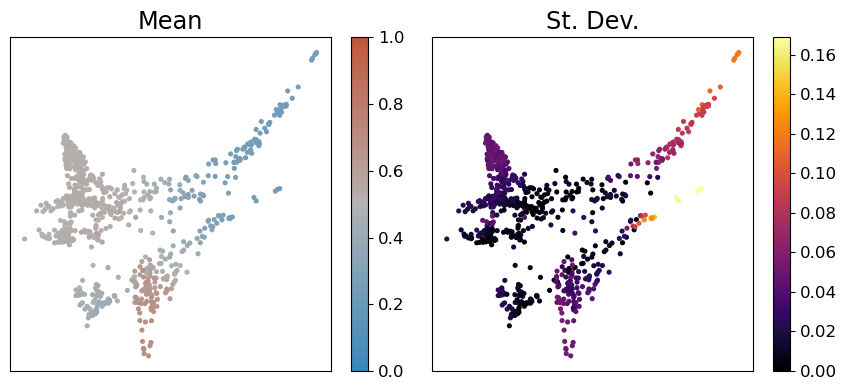

In [23]:
fig, axes = plt.subplots(1,2, figsize=(8.7,4))
scprep.plot.scatter2d(data_phate[condition], c=sample_likelihoods[experimental_samples].mean(axis=1), 
                      cmap=meld.get_meld_cmap(), vmin=0, vmax=1,
                      title='Mean', ticks=False, ax=axes[0])
scprep.plot.scatter2d(data_phate[condition], c=sample_likelihoods[experimental_samples].std(axis=1), vmin=0, 
                      cmap='inferno', title='St. Dev.', ticks=False, ax=axes[1])

fig.tight_layout()

## Iterate over groups

In [24]:
# Convert the unique values to a list
unique_values_list = metadata['sgRNA_group'].unique().tolist()

pd.set_option('display.max_rows', None)  # This sets the maximum number of rows to display to unlimited
print(unique_values_list)

# Assuming you have a 1-D array called 'groups' that you want to iterate over, including 'tfec'
# groups = ['erf_erfl3', 'fli1a_erf_erfl3', 'mitfa', 'mitfa_tfec',
#        'multiplet', 'negative', 'nr2f5', 'rarga', 'rxraa', 'tfec']  
os.chdir("perturb_seq/analysis/differential_analysis/figures/meld_calculateLikelihood")
groups=['fli1a_erf_erfl3', 'mitfa_tfec_inhouse',  'erf_erfl3', 'mitfa', 'rarga', 'nr2f5', 
        'tfec', 'rxraa', 'fli1a_elk3', 'tfec_mitfa_bhlhe40', 'etv2', 'elk3', 'mitfa_tfec',
        'mitfa_tfec_tfeb', 'fli1a_etv2', 'smarcc1a', 'erf', 'fli1a', 'ebf3a', 'elf1', 'nr2f2', 'ets1']

['fli1a_erf_erfl3', 'mitfa_tfec_inhouse', 'multiplet', 'control', 'negative', 'erf_erfl3', 'mitfa', 'rarga', 'nr2f5', 'tfec', 'rxraa', 'fli1a_elk3', 'tfec_mitfa_bhlhe40', 'etv2', 'elk3', 'mitfa_tfec', 'mitfa_tfec_tfeb', 'fli1a_etv2', 'smarcc1a', 'erf', 'fli1a', 'ebf3a', 'elf1', 'nr2f2', 'ets1']


Building graph on 1035 samples and 50 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 0.08 seconds.
  Calculating affinities...
Calculated graph and diffusion operator in 0.11 seconds.


/tmp/ipykernel_12687/1716300614.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_small['replicate'] = random_assignments
/tmp/ipykernel_12687/1716300614.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_small['sample_labels'] = metadata_small['sgRNA_group'].astype(str) + metadata_small['replicate']


Building graph on 1213 samples and 50 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 0.11 seconds.
  Calculating affinities...
Calculated graph and diffusion operator in 0.13 seconds.


/tmp/ipykernel_12687/1716300614.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_small['replicate'] = random_assignments
/tmp/ipykernel_12687/1716300614.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_small['sample_labels'] = metadata_small['sgRNA_group'].astype(str) + metadata_small['replicate']


Building graph on 2137 samples and 50 features.
Calculating graph and diffusion operator...
  Calculating KNN search...


/tmp/ipykernel_12687/1716300614.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_small['replicate'] = random_assignments
/tmp/ipykernel_12687/1716300614.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_small['sample_labels'] = metadata_small['sgRNA_group'].astype(str) + metadata_small['replicate']


  Calculated KNN search in 0.30 seconds.
  Calculating affinities...
Calculated graph and diffusion operator in 0.34 seconds.
Building graph on 1055 samples and 50 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 0.08 seconds.
  Calculating affinities...
Calculated graph and diffusion operator in 0.10 seconds.


/tmp/ipykernel_12687/1716300614.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_small['replicate'] = random_assignments
/tmp/ipykernel_12687/1716300614.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_small['sample_labels'] = metadata_small['sgRNA_group'].astype(str) + metadata_small['replicate']


Building graph on 965 samples and 50 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 0.07 seconds.
  Calculating affinities...
Calculated graph and diffusion operator in 0.17 seconds.


/tmp/ipykernel_12687/1716300614.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_small['replicate'] = random_assignments
/tmp/ipykernel_12687/1716300614.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_small['sample_labels'] = metadata_small['sgRNA_group'].astype(str) + metadata_small['replicate']


Building graph on 757 samples and 50 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 0.04 seconds.
  Calculating affinities...
Calculated graph and diffusion operator in 0.06 seconds.


/tmp/ipykernel_12687/1716300614.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_small['replicate'] = random_assignments
/tmp/ipykernel_12687/1716300614.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_small['sample_labels'] = metadata_small['sgRNA_group'].astype(str) + metadata_small['replicate']


Building graph on 779 samples and 50 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 0.05 seconds.
  Calculating affinities...
Calculated graph and diffusion operator in 0.06 seconds.


/tmp/ipykernel_12687/1716300614.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_small['replicate'] = random_assignments
/tmp/ipykernel_12687/1716300614.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_small['sample_labels'] = metadata_small['sgRNA_group'].astype(str) + metadata_small['replicate']


Building graph on 878 samples and 50 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 0.06 seconds.
  Calculating affinities...
Calculated graph and diffusion operator in 0.08 seconds.


/tmp/ipykernel_12687/1716300614.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_small['replicate'] = random_assignments
/tmp/ipykernel_12687/1716300614.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_small['sample_labels'] = metadata_small['sgRNA_group'].astype(str) + metadata_small['replicate']


Building graph on 812 samples and 50 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 0.05 seconds.
  Calculating affinities...
Calculated graph and diffusion operator in 0.07 seconds.


/tmp/ipykernel_12687/1716300614.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_small['replicate'] = random_assignments
/tmp/ipykernel_12687/1716300614.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_small['sample_labels'] = metadata_small['sgRNA_group'].astype(str) + metadata_small['replicate']


Building graph on 775 samples and 50 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 0.05 seconds.
  Calculating affinities...
Calculated graph and diffusion operator in 0.06 seconds.


/tmp/ipykernel_12687/1716300614.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_small['replicate'] = random_assignments
/tmp/ipykernel_12687/1716300614.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_small['sample_labels'] = metadata_small['sgRNA_group'].astype(str) + metadata_small['replicate']


Building graph on 792 samples and 50 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 0.05 seconds.
  Calculating affinities...
Calculated graph and diffusion operator in 0.07 seconds.


/tmp/ipykernel_12687/1716300614.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_small['replicate'] = random_assignments
/tmp/ipykernel_12687/1716300614.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_small['sample_labels'] = metadata_small['sgRNA_group'].astype(str) + metadata_small['replicate']
/tmp/ipykernel_12687/1716300614.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until 

Building graph on 834 samples and 50 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 0.05 seconds.
  Calculating affinities...
Calculated graph and diffusion operator in 0.07 seconds.


/tmp/ipykernel_12687/1716300614.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_small['replicate'] = random_assignments
/tmp/ipykernel_12687/1716300614.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_small['sample_labels'] = metadata_small['sgRNA_group'].astype(str) + metadata_small['replicate']


Building graph on 1552 samples and 50 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 0.17 seconds.
  Calculating affinities...


/tmp/ipykernel_12687/1716300614.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_small['replicate'] = random_assignments
/tmp/ipykernel_12687/1716300614.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_small['sample_labels'] = metadata_small['sgRNA_group'].astype(str) + metadata_small['replicate']


Calculated graph and diffusion operator in 0.20 seconds.
Building graph on 1595 samples and 50 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 0.18 seconds.
  Calculating affinities...


/tmp/ipykernel_12687/1716300614.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_small['replicate'] = random_assignments
/tmp/ipykernel_12687/1716300614.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_small['sample_labels'] = metadata_small['sgRNA_group'].astype(str) + metadata_small['replicate']


Calculated graph and diffusion operator in 0.21 seconds.
Building graph on 1325 samples and 50 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 0.12 seconds.
  Calculating affinities...
Calculated graph and diffusion operator in 0.15 seconds.


/tmp/ipykernel_12687/1716300614.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_small['replicate'] = random_assignments
/tmp/ipykernel_12687/1716300614.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_small['sample_labels'] = metadata_small['sgRNA_group'].astype(str) + metadata_small['replicate']


Building graph on 1314 samples and 50 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 0.12 seconds.
  Calculating affinities...
Calculated graph and diffusion operator in 0.15 seconds.


/tmp/ipykernel_12687/1716300614.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_small['replicate'] = random_assignments
/tmp/ipykernel_12687/1716300614.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_small['sample_labels'] = metadata_small['sgRNA_group'].astype(str) + metadata_small['replicate']


Building graph on 957 samples and 50 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 0.07 seconds.
  Calculating affinities...
Calculated graph and diffusion operator in 0.09 seconds.


/tmp/ipykernel_12687/1716300614.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_small['replicate'] = random_assignments
/tmp/ipykernel_12687/1716300614.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_small['sample_labels'] = metadata_small['sgRNA_group'].astype(str) + metadata_small['replicate']


Building graph on 1117 samples and 50 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 0.09 seconds.
  Calculating affinities...
Calculated graph and diffusion operator in 0.12 seconds.


/tmp/ipykernel_12687/1716300614.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_small['replicate'] = random_assignments
/tmp/ipykernel_12687/1716300614.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_small['sample_labels'] = metadata_small['sgRNA_group'].astype(str) + metadata_small['replicate']


Building graph on 730 samples and 50 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 0.04 seconds.
  Calculating affinities...
Calculated graph and diffusion operator in 0.06 seconds.


/tmp/ipykernel_12687/1716300614.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_small['replicate'] = random_assignments
/tmp/ipykernel_12687/1716300614.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_small['sample_labels'] = metadata_small['sgRNA_group'].astype(str) + metadata_small['replicate']


Building graph on 779 samples and 50 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 0.05 seconds.
  Calculating affinities...
Calculated graph and diffusion operator in 0.06 seconds.


/tmp/ipykernel_12687/1716300614.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_small['replicate'] = random_assignments
/tmp/ipykernel_12687/1716300614.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_small['sample_labels'] = metadata_small['sgRNA_group'].astype(str) + metadata_small['replicate']


Building graph on 834 samples and 50 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 0.05 seconds.
  Calculating affinities...
Calculated graph and diffusion operator in 0.07 seconds.


/tmp/ipykernel_12687/1716300614.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_small['replicate'] = random_assignments
/tmp/ipykernel_12687/1716300614.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_small['sample_labels'] = metadata_small['sgRNA_group'].astype(str) + metadata_small['replicate']


Building graph on 834 samples and 50 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 0.05 seconds.
  Calculating affinities...
Calculated graph and diffusion operator in 0.07 seconds.


/tmp/ipykernel_12687/1716300614.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_small['replicate'] = random_assignments
/tmp/ipykernel_12687/1716300614.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_small['sample_labels'] = metadata_small['sgRNA_group'].astype(str) + metadata_small['replicate']


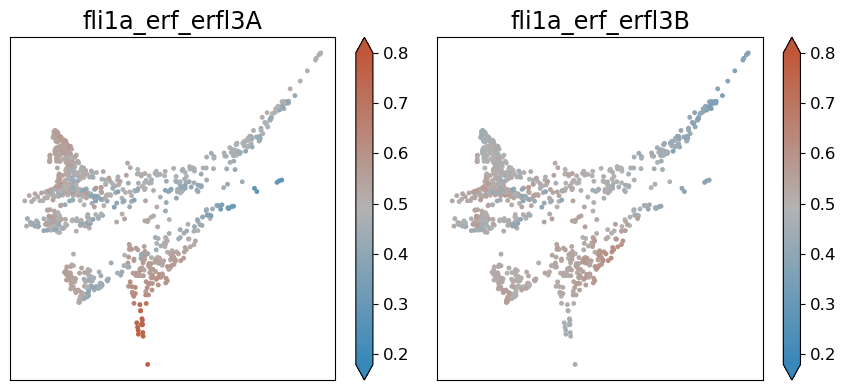

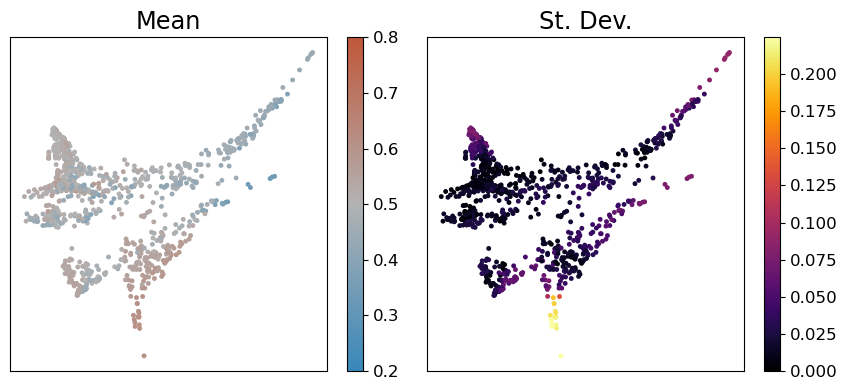

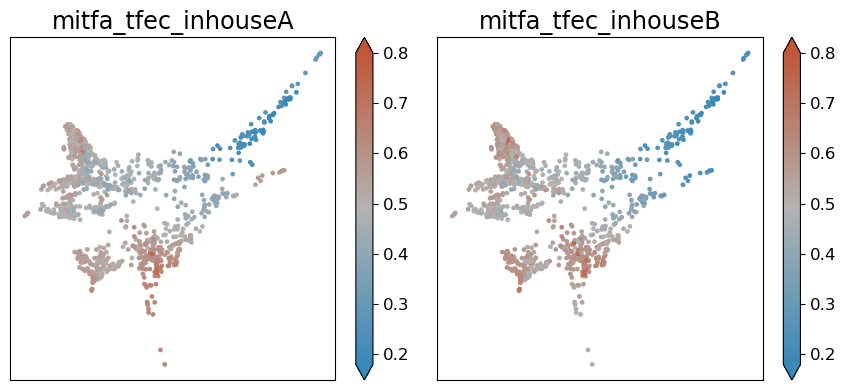

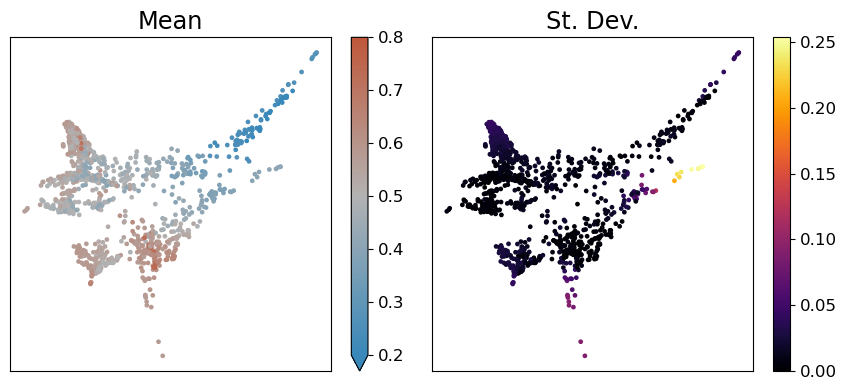

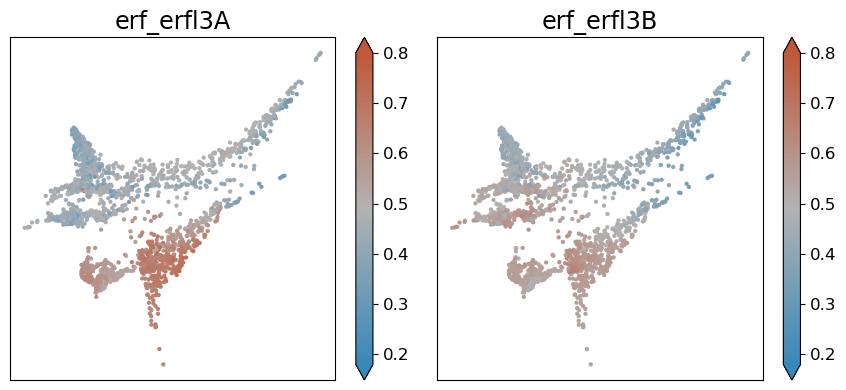

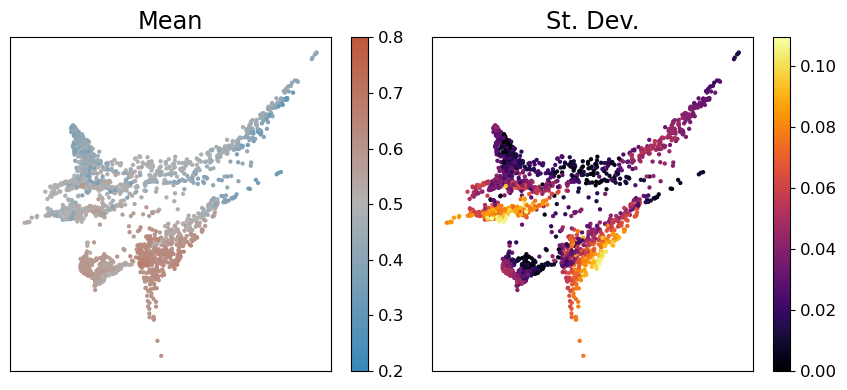

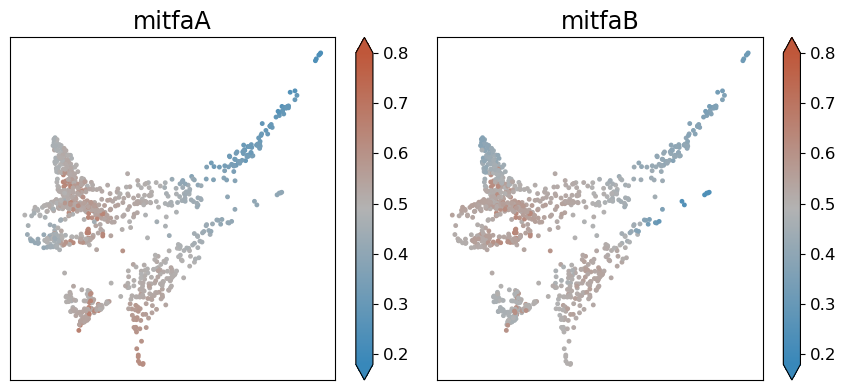

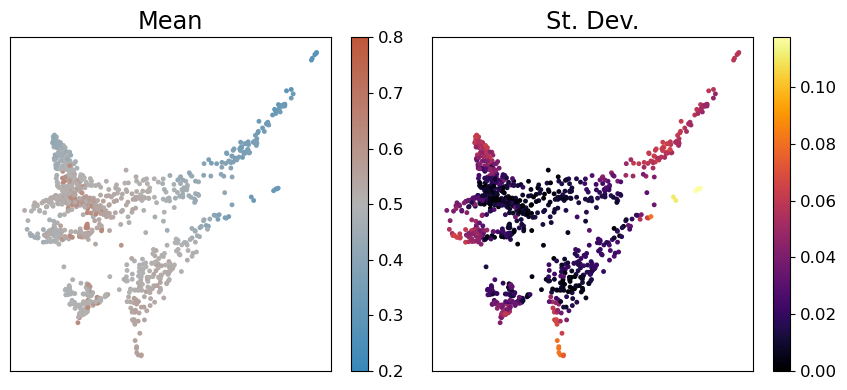

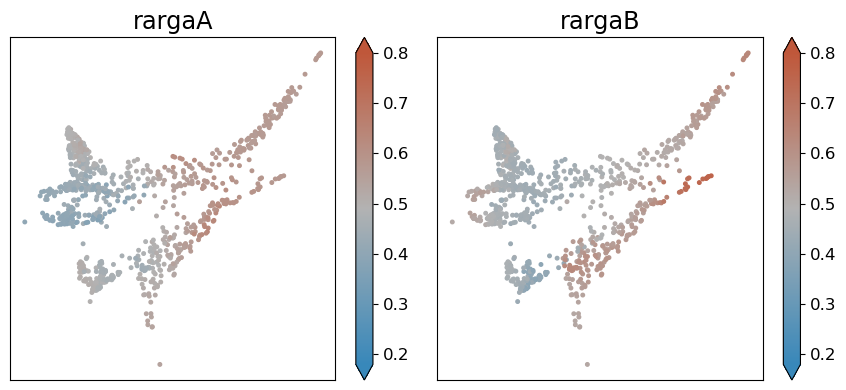

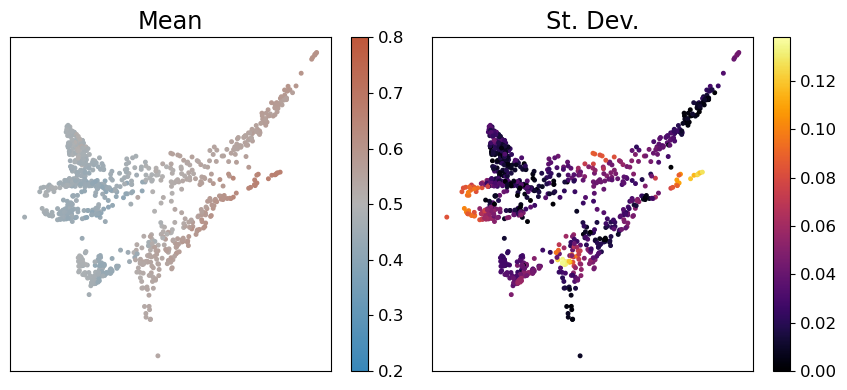

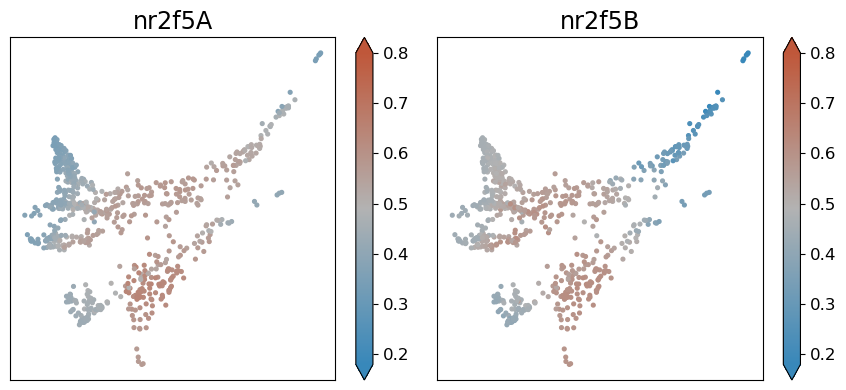

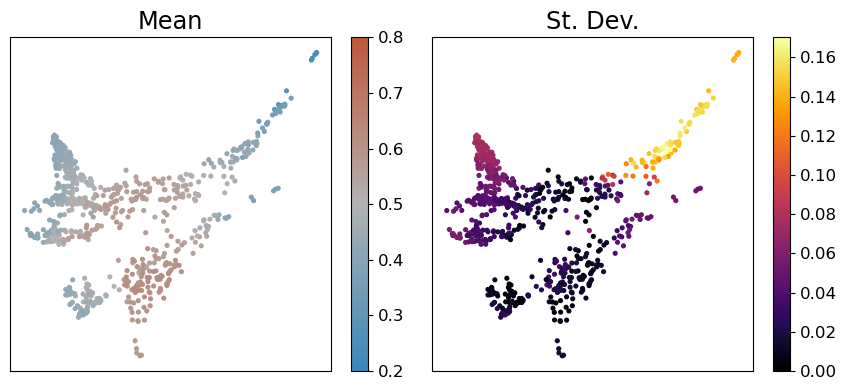

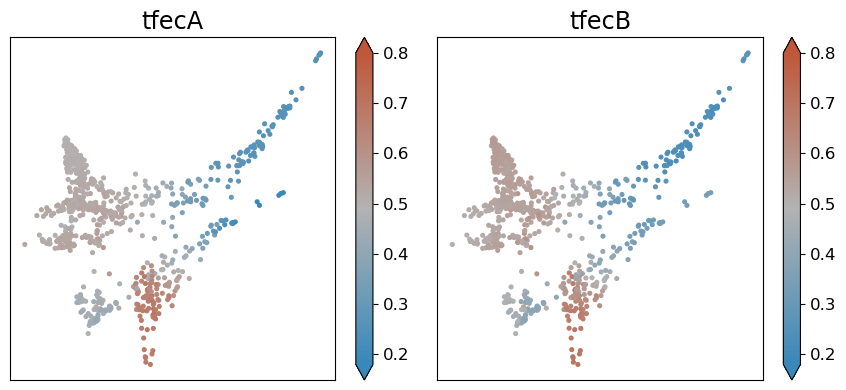

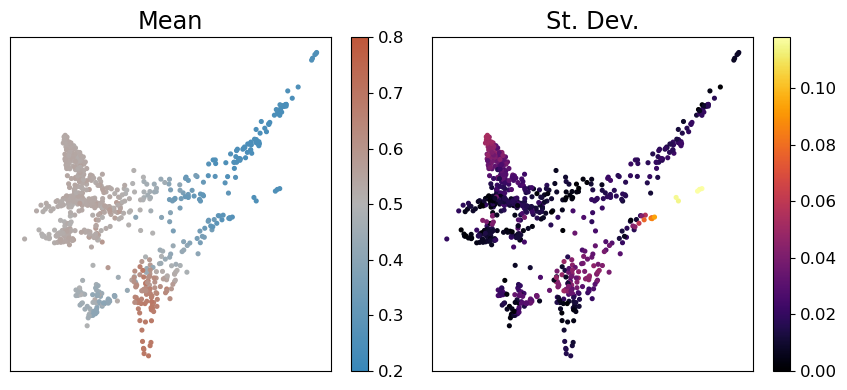

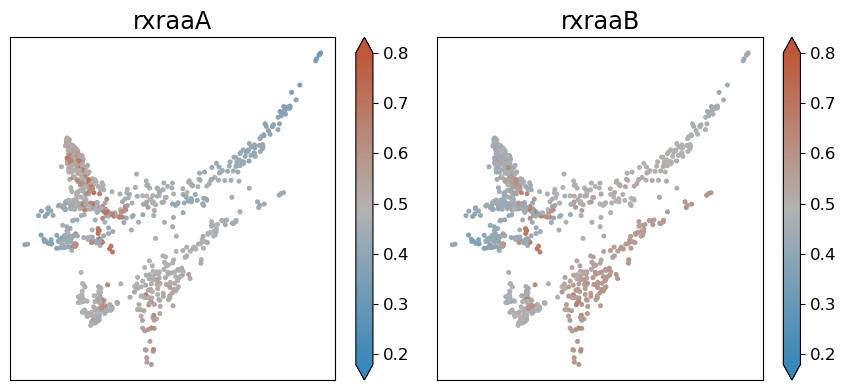

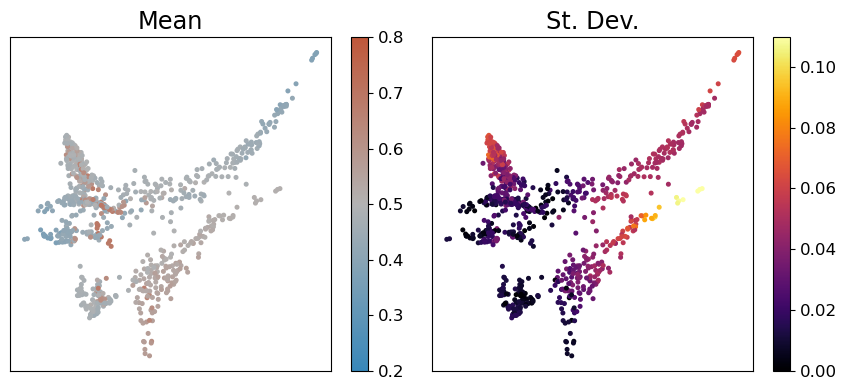

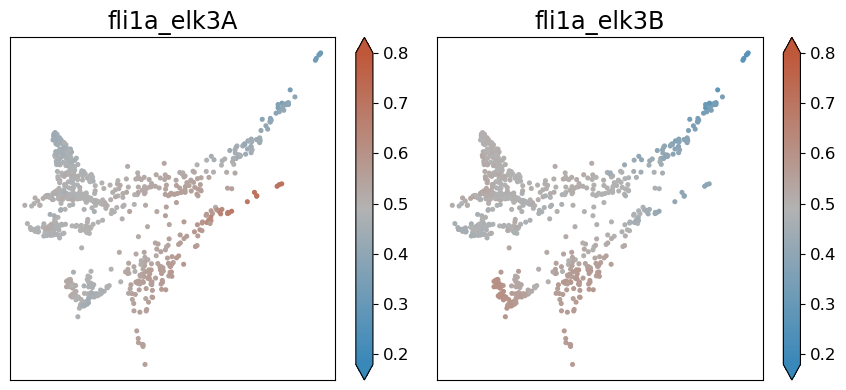

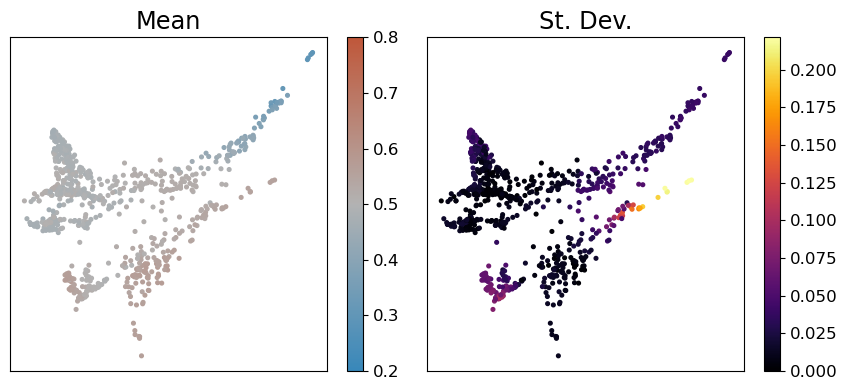

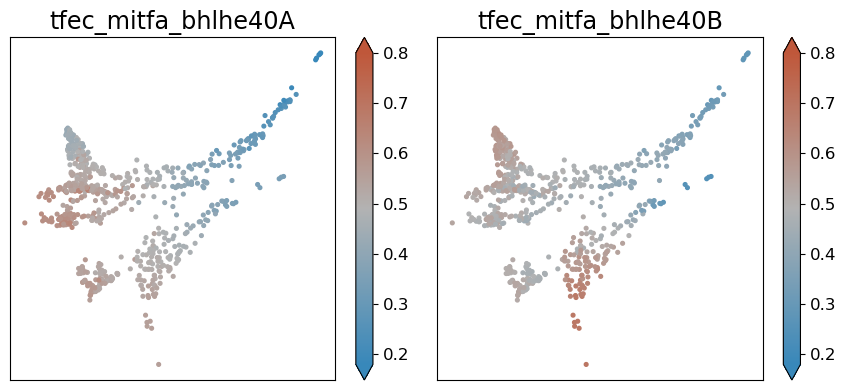

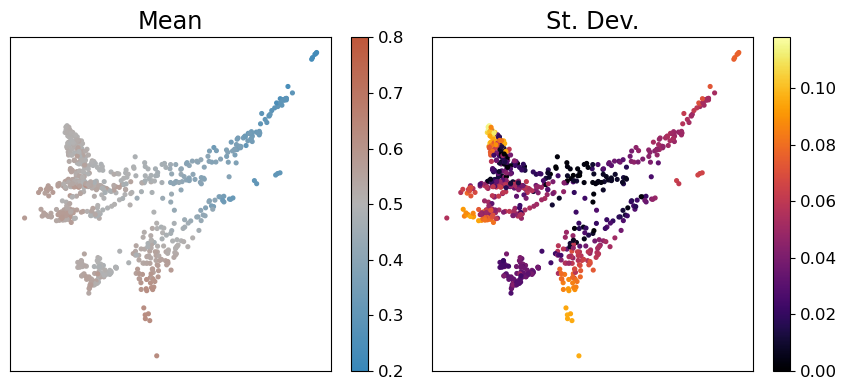

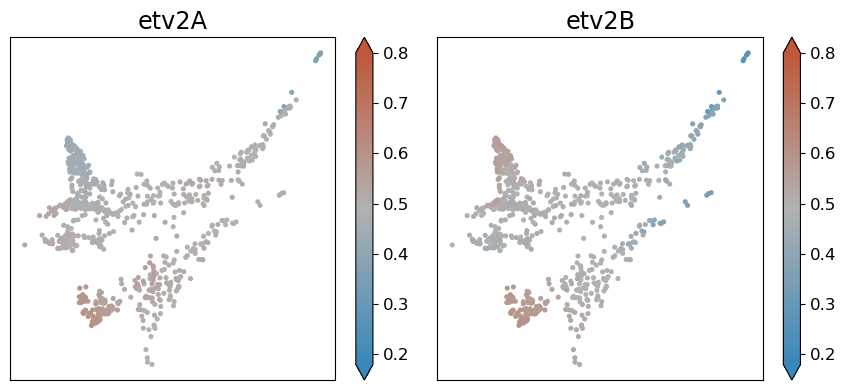

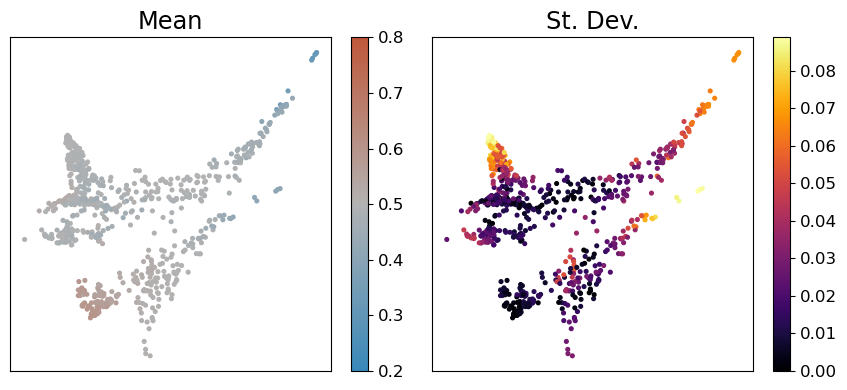

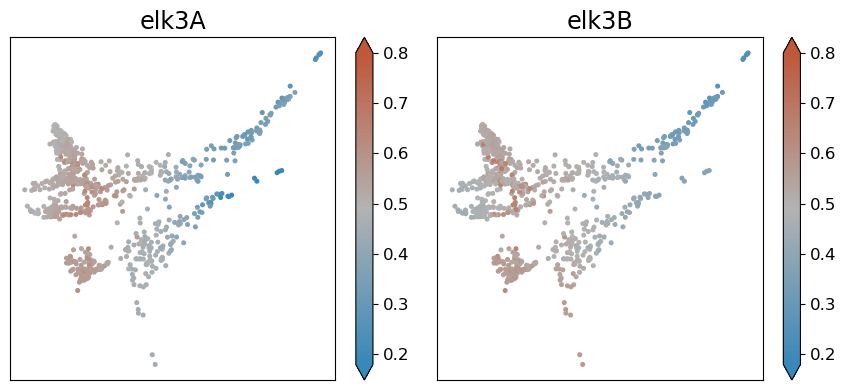

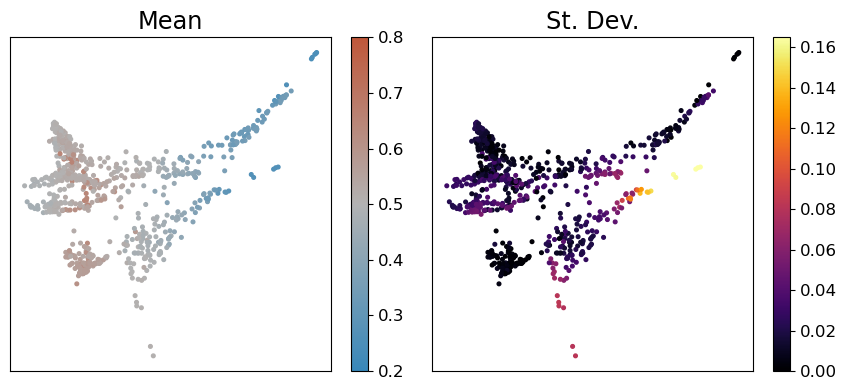

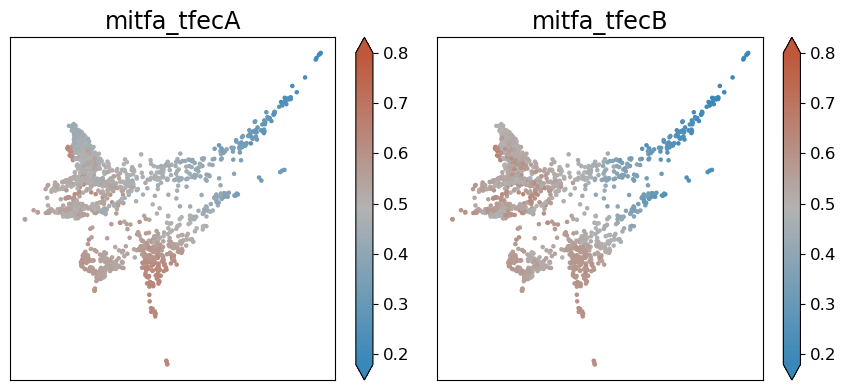

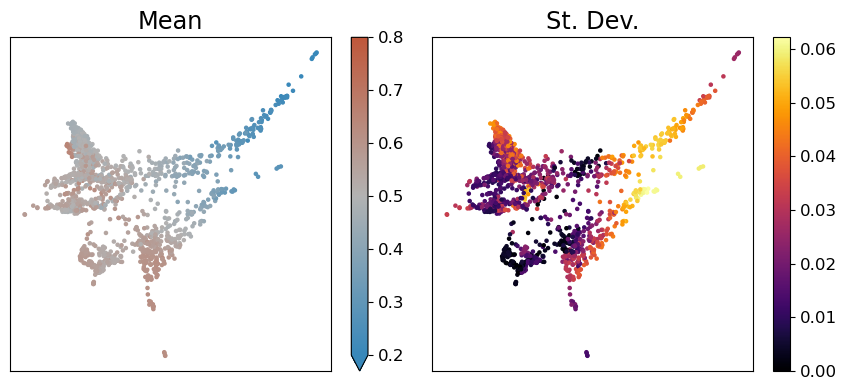

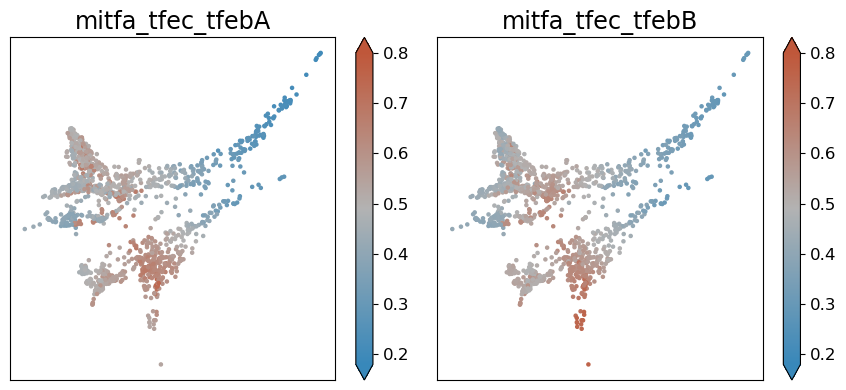

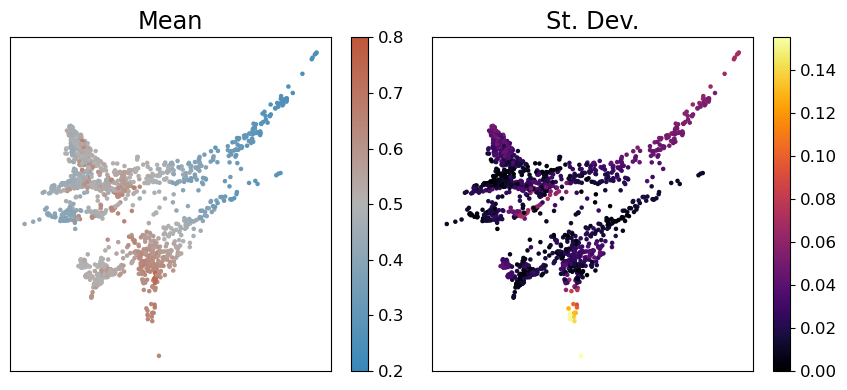

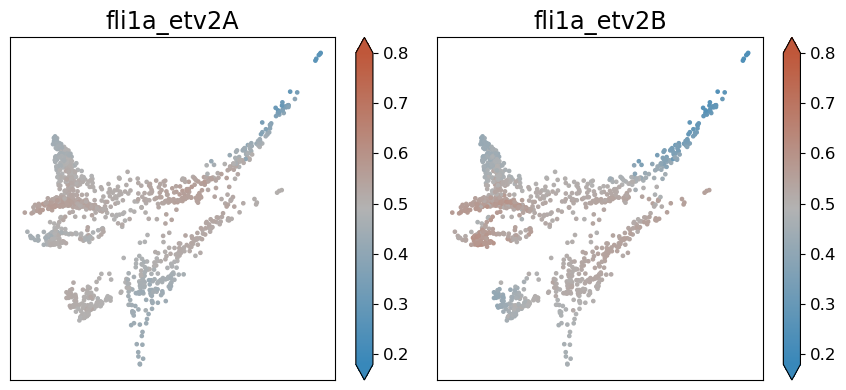

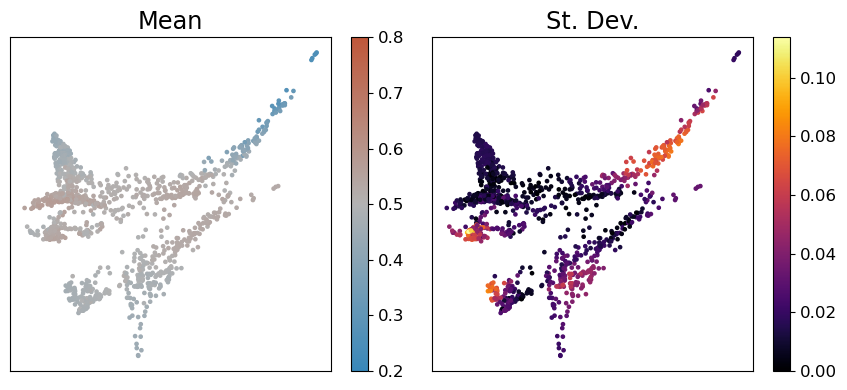

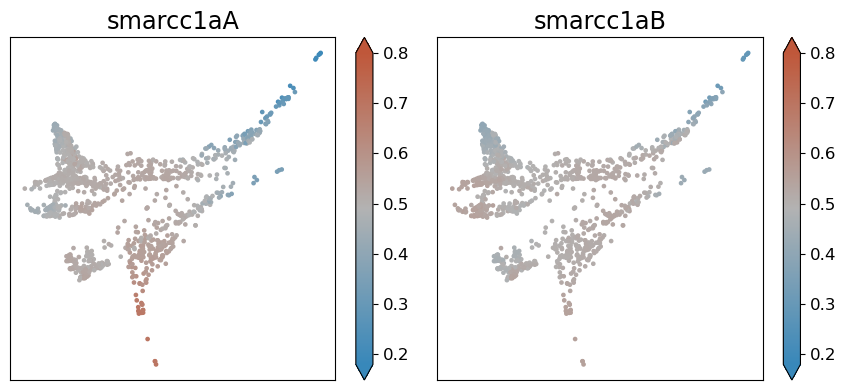

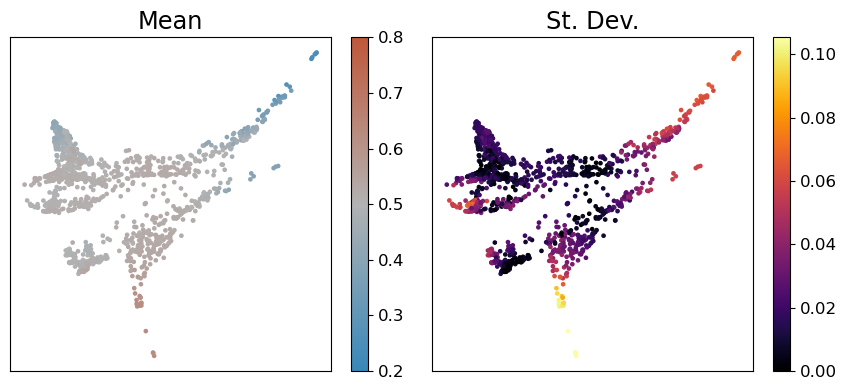

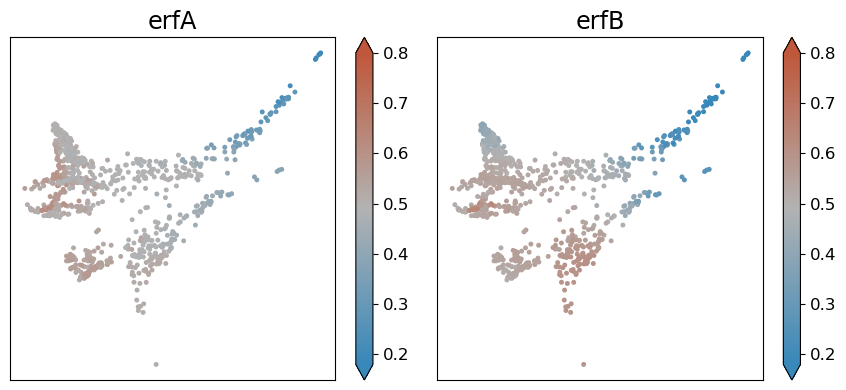

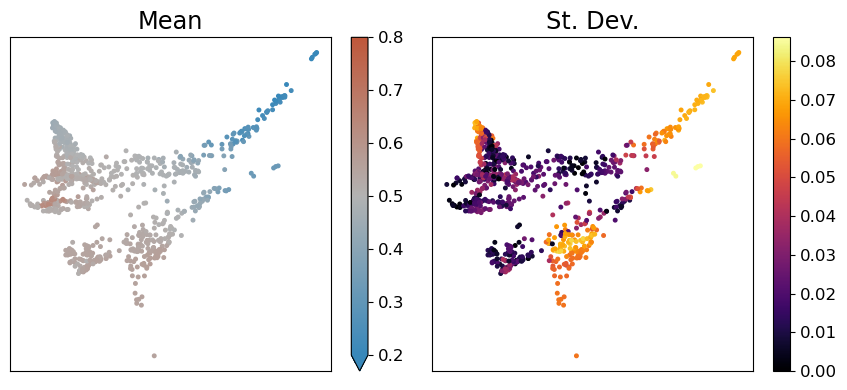

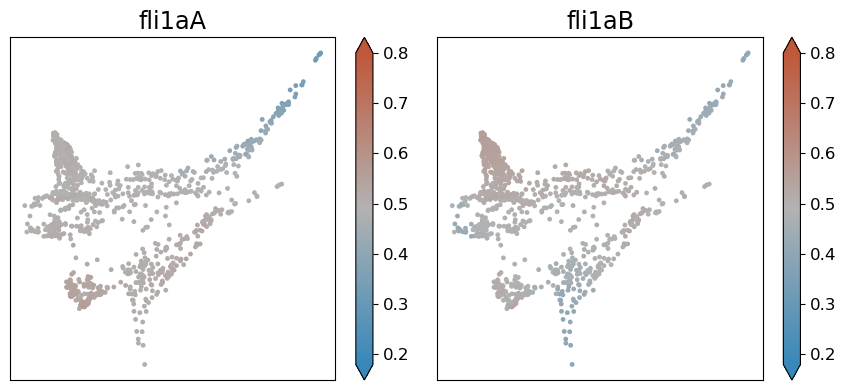

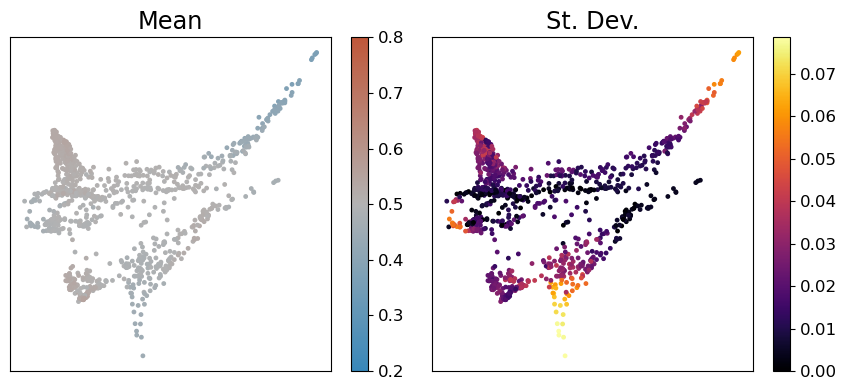

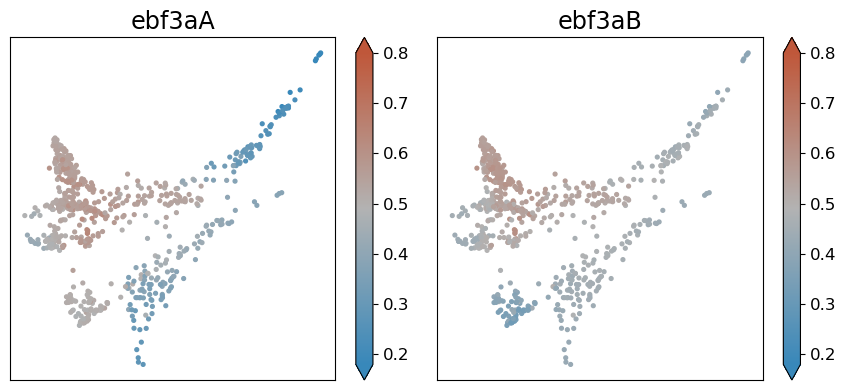

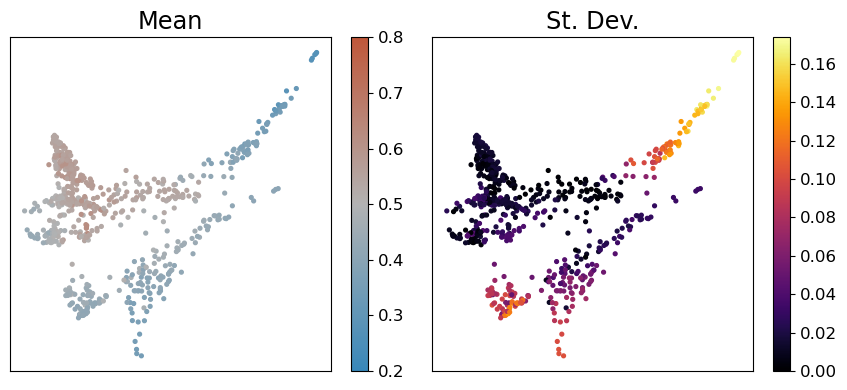

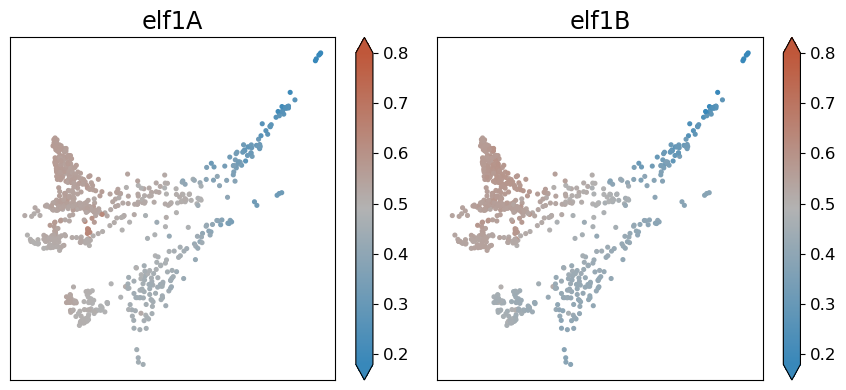

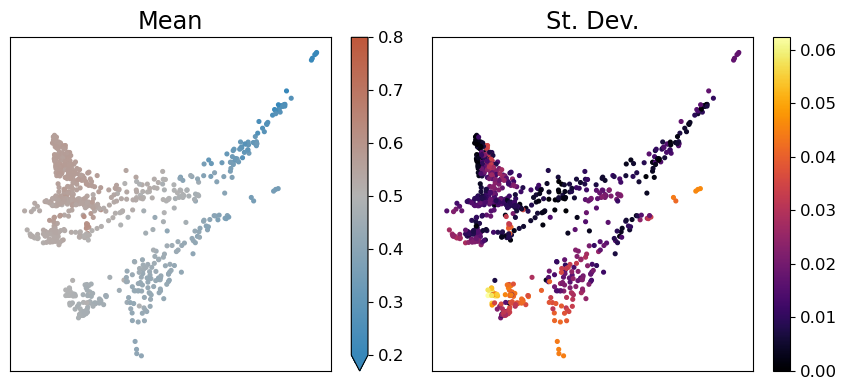

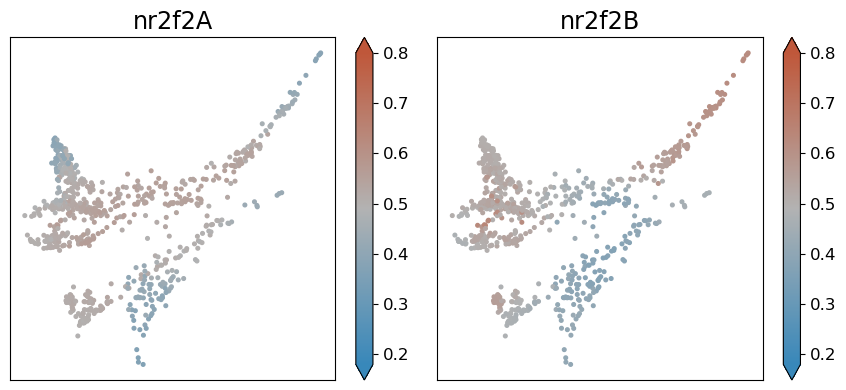

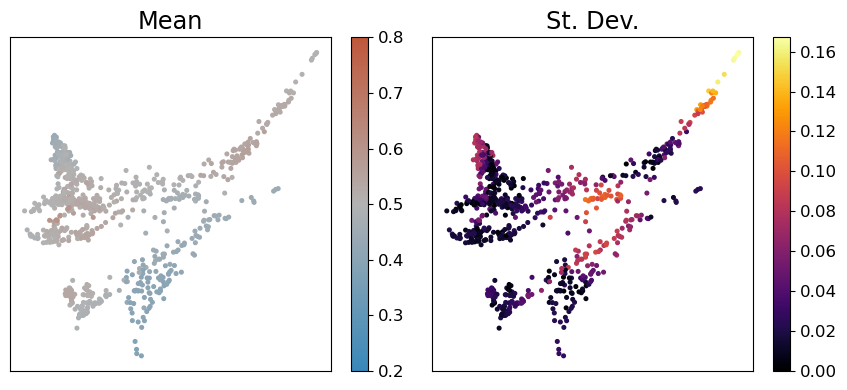

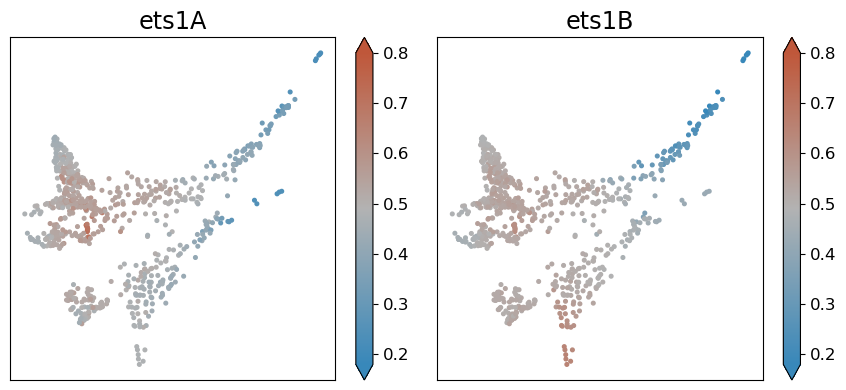

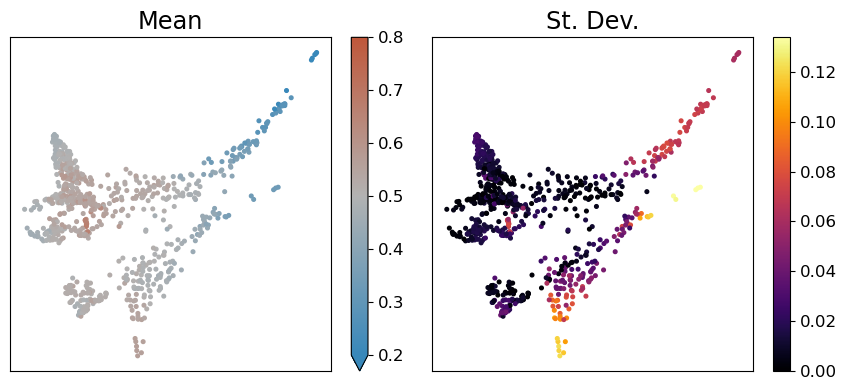

In [25]:
# Iterate over each group
for group in groups:
    #--------------------------------------#
    # Select condition for comparison based on the current group #
    #--------------------------------------#

    condition = (metadata['sgRNA_group'] == 'control') | (metadata['sgRNA_group'] == group)

    # Use the mask to subset the DataFrame
    metadata_small = metadata[condition]

    # Assuming metadata is a DataFrame with a 'replicate' column
    # Create an array of random 'A' and 'B' values
    random_assignments = np.random.choice(['A', 'B'], size=len(metadata_small))

    # Assign the random values to the 'replicate' column
    metadata_small['replicate'] = random_assignments

    meld_op = meld.MELD(beta=beta, knn=knn)
    metadata_small['sample_labels'] = metadata_small['sgRNA_group'].astype(str) + metadata_small['replicate']
    sample_densities = meld_op.fit_transform(data_pca[condition], sample_labels=metadata_small['sample_labels'])

    sample_likelihoods = replicate_normalize_densities(sample_densities, metadata_small['replicate'])
  
    # Sample associated relative likelihoods for each condition.
    experimental_samples = [f'{group}A', f'{group}B']

    fig, axes = plt.subplots(1, 2, figsize=(8.7, 4))
    for curr_sample, ax in zip(experimental_samples, axes):
        scprep.plot.scatter2d(data_phate[condition], c=sample_likelihoods[curr_sample], cmap=meld.get_meld_cmap(),
                              vmin=0.8, vmax=0.2,
                              title=curr_sample, ticks=False, ax=ax)
    fig.tight_layout()
    fig.savefig(f'likelihood_{group}.png')

    fig, axes = plt.subplots(1, 2, figsize=(8.7, 4))
    scprep.plot.scatter2d(data_phate[condition], c=sample_likelihoods[experimental_samples].mean(axis=1),
                          cmap=meld.get_meld_cmap(), vmin=0.2, vmax=0.8,
                          title='Mean', ticks=False, ax=axes[0])
    scprep.plot.scatter2d(data_phate[condition], c=sample_likelihoods[experimental_samples].std(axis=1), vmin=0, 
                          cmap='inferno', title='St. Dev.', ticks=False, ax=axes[1])
    fig.tight_layout()
    fig.savefig(f'likelihood_meanSTD_{group}.png')
    
    # Define a unique file name for each iteration
    filename = f"likelihood_{group}.csv"  # or "output_{}.csv".format(i) for Python <3.6

    # Write DataFrame to file
    sample_likelihoods.to_csv(filename, index=True)



In [28]:
phate_df.to_csv("perturb_seq/analysis/differential_analysis/data/phate_coordinates.csv")
metadata.to_csv("perturb_seq/analysis/differential_analysis/data/metadata.csv")